## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizontal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

print(CWD, os.getcwd())
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/gray /Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/gray


'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


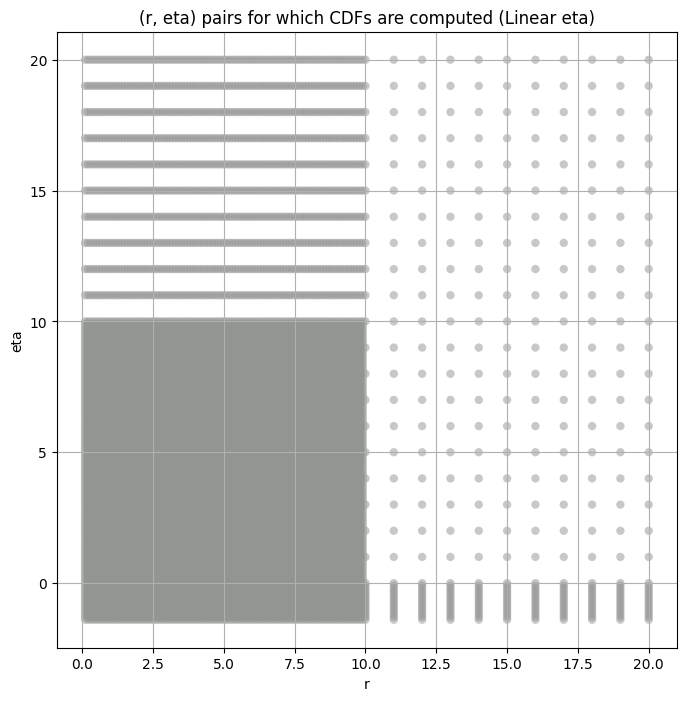

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5815.229500  5348.870000  6287.341300  -0.441054   -0.602250   
3      1326.074800  1255.579700  1397.486600   0.761781    0.544982   
4       292.659240   276.629640   309.142120   2.614651    2.138453   
5        55.126610    51.472590    58.957115   5.036825    3.927359   
6        10.025225     9.217633    10.903786   8.688152    6.635766   
7         1.785368     1.608343     1.986916  14.651720   10.383094   
8         0.343946     0.302026     0.396024  24.972425   15.453585   
9         0.075908     0.064915     0.091704  42.067000   20.209116   

       kurt_upper  total_samples  
layer                             
2       -0.259446         1604.0  
3        0.992033         6416.0  
4        3.358012        25664.0  
5        7.035570       102656.0  
6       15.399898       410624.0  
7       29.135918      1642496.0  
8       71.256620      6569984.0  
9      144.260740     26279936.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      5815.229500    5815.229492     5023.307129     4453.192383   
3      1326.074800    1326.074829     1223.192871     1151.337280   
4       292.659240     292.659241      280.556458      272.017670   
5        55.126610      55.126610       53.872818       53.105412   
6        10.025225      10.025225        9.727292        9.536486   
7         1.785368       1.785368        1.708845        1.662088   
8         0.343946       0.343946        0.323616        0.311903   
9         0.075908       0.075908        0.069781        0.066647   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         3997.054932      3593.183838      2916.131348      2356.390869   
3         1091.012329      1039.441772       950.713928       876.928711   
4          264.677826       258.020447       246.242920       236.187622   
5           52.423313        51.794918        50.668728        49.670025   
6            9.371657         9.222933         8.958463         8.722877   
7            1.622391         1.587274         1.526032         1.473139   
8            0.302148         0.293583         0.278861         0.266317   
9            0.064100         0.061901         0.058190         0.055098   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1896.837646      1515.809204      1179.121826       489.180267  
3           812.183899       752.945312       699.393372       568.402527  
4           227.288132       219.291611       211.937454       192.847549  
5            48.757069        47.905598        47.106136        44.963127  
6             8.508615         8.311345         8.128497         7.642523  
7             1.426180         1.383639         1.344586         1.243453  
8             0.255325         0.245526         0.236675         0.214320  
9             0.052430         0.050084         0.047990         0.042790

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.10045038169551795 5815.2295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.10897018925920876 5023.307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.12071908061631542 4453.1924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.13305533511518097 3997.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.1454600197856475 3593.1838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.17030690992820086 2916.1313


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.19603283223524148 2356.3909


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.22202144234204657 1896.8376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.24792295755493188 1515.8092


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.27513564966982806 1179.1218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.3590442923247449 489.18027
Number of samples: 1604, Without approximation : 1604.0


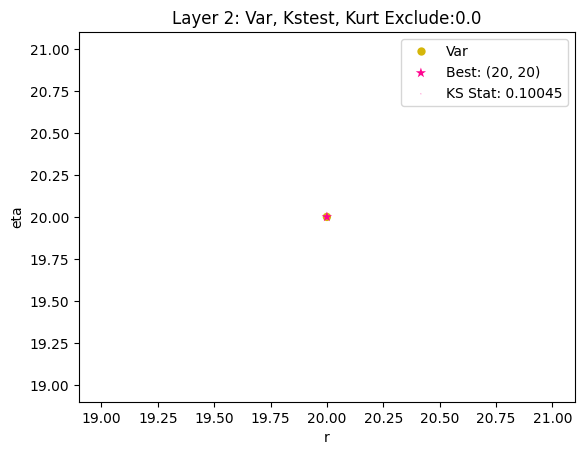

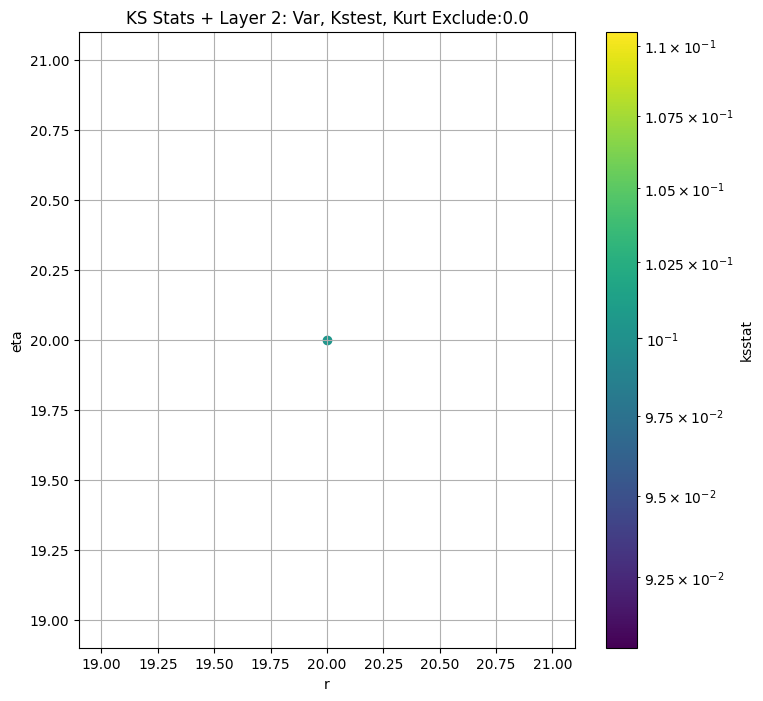

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.058646908270747256 1326.0748


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.05864178892964517 1223.1929


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.05863545710337009 1151.3373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.05863766326786052 1091.0123


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.058637412498939445 1039.4418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.05863267579284509 950.7139


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.058632292712292144 876.9287


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.06342386225018604 812.1839


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.0718032923630536 752.9453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.07973168733718139 699.3934


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.10352674743102819 568.4025
Number of samples: 6416, Without approximation : 6416.0


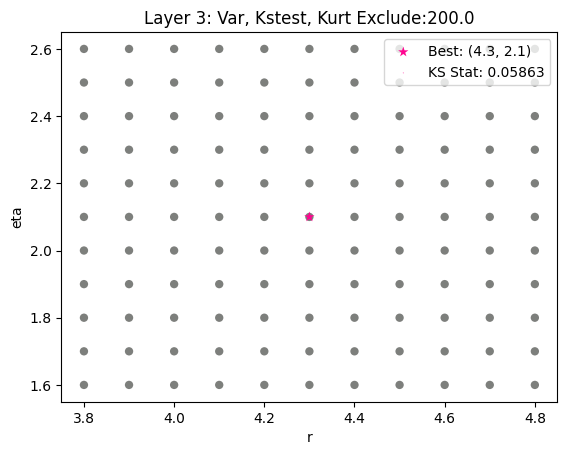

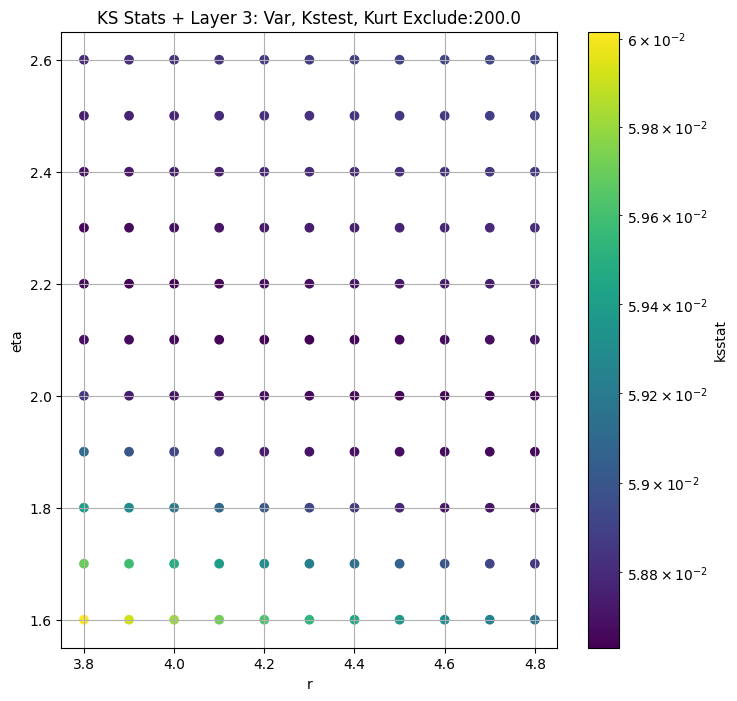

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.045271017150417814 292.65924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.04529395949418469 280.55646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.045395613107196975 272.01767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.045397623803957676 264.67783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.045394114343339065 258.02045


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.04538417161359315 246.24292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.04539559528795617 236.18762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.04538987605896683 227.28813


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.045388889191178894 219.29161


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.04539251494095198 211.93745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.045626276302524194 192.84755
Number of samples: 25664, Without approximation : 25664.0


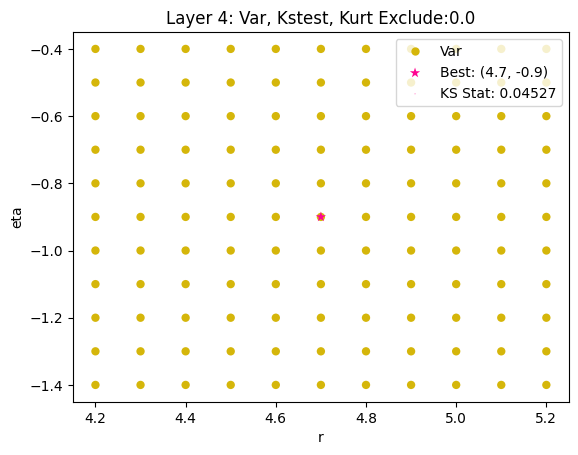

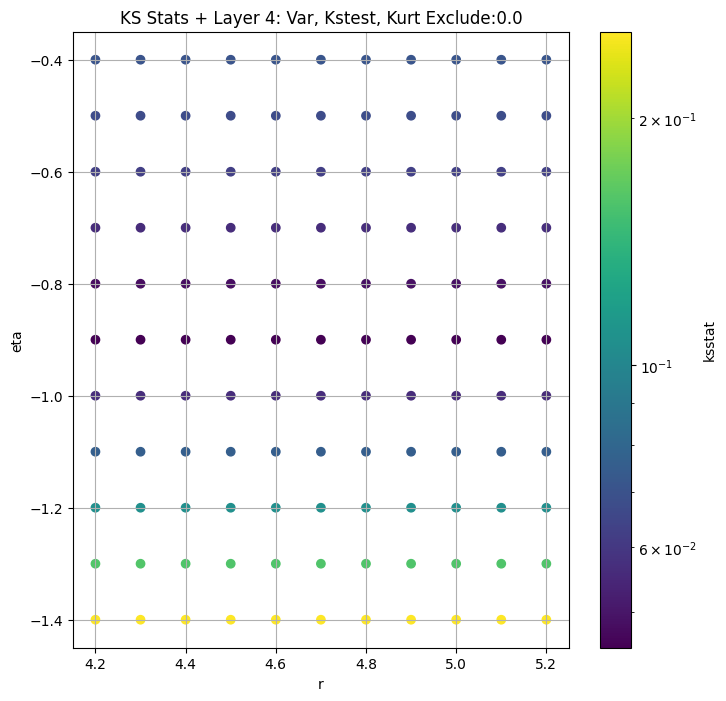

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03338816228622604 55.12661


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.033371435218812695 53.872818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.033360911452538666 53.10541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03335136781887055 52.423313


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.033342412382536435 51.794918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03332595581916109 50.668728


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03331090548559107 49.670025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03331970012137131 48.75707


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0333842341198185 47.905598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03337249268536863 47.106136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03333953593420885 44.963127
Number of samples: 100000, Without approximation : 102656.0


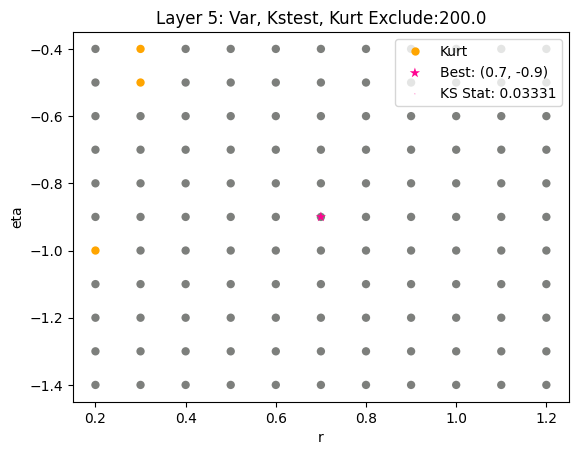

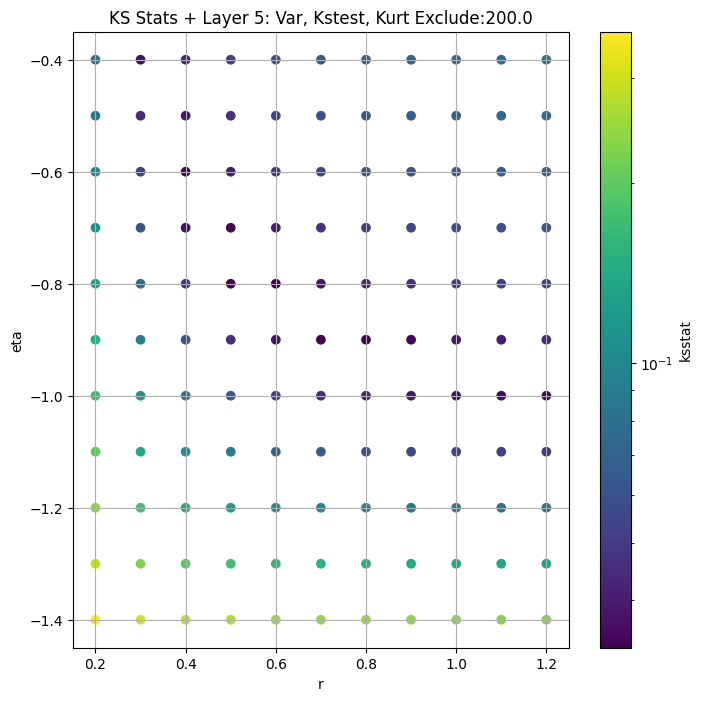

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.03322967043945546 10.025225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.03323058014529767 9.727292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.033500865125334456 9.536486


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.03338321504505526 9.371657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.03332127493687753 9.222933


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.03321233348123964 8.958463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.033325927995411564 8.722877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.033357313590160365 8.5086155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.0332649476542608 8.311345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.033192126817539136 8.128497


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.0331897313864728 7.642523
Number of samples: 100000, Without approximation : 410624.0


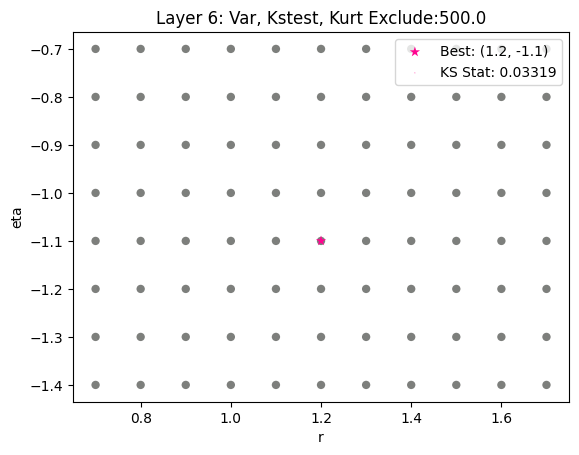

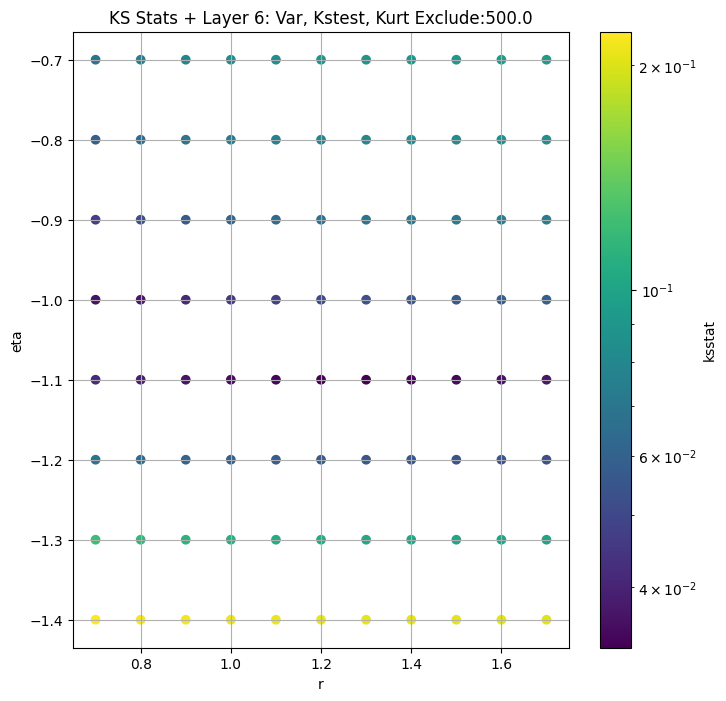

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.034162839379565324 1.7853681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.03437961145774904 1.7088449


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.03490235521185647 1.6620884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.034655872631404905 1.6223906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.03443109384430082 1.587274


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.03402298602359416 1.5260322


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.03478516649628477 1.4731389


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.034452492687351954 1.42618


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.03413844504461755 1.3836395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.03465085955026881 1.344586


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.034621533825612616 1.2434528
Number of samples: 100000, Without approximation : 1642496.0


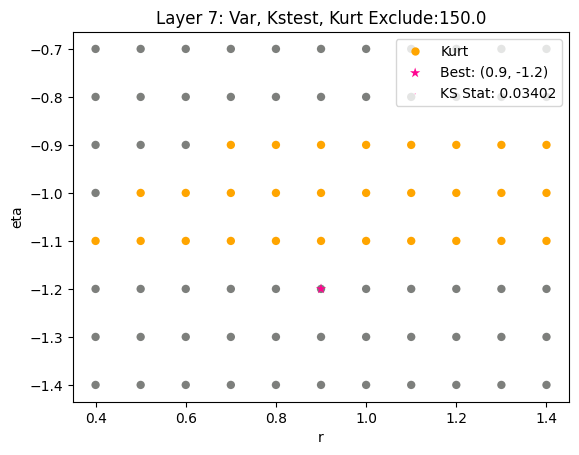

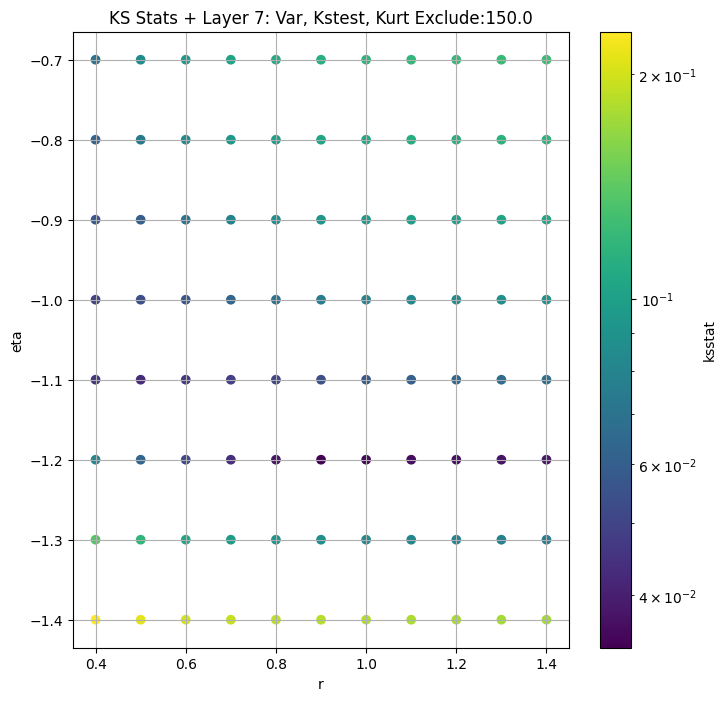

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.01553004991653495 0.34394595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.017212994816544813 0.32361645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.018271228593360833 0.3119028


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.01919854747288474 0.30214795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.02004629452629081 0.29358274


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.021201066477733566 0.27886072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.02059315629306696 0.26631737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.02003322303694599 0.25532496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.019506828642658902 0.245526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.019860624032731783 0.23667504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.01662354274038058 0.21431968
Number of samples: 100000, Without approximation : 6569984.0


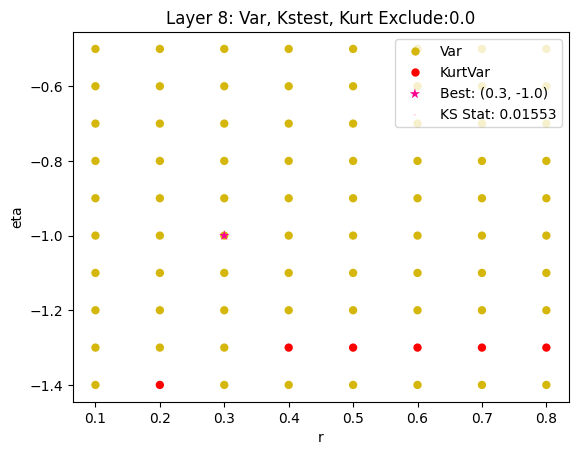

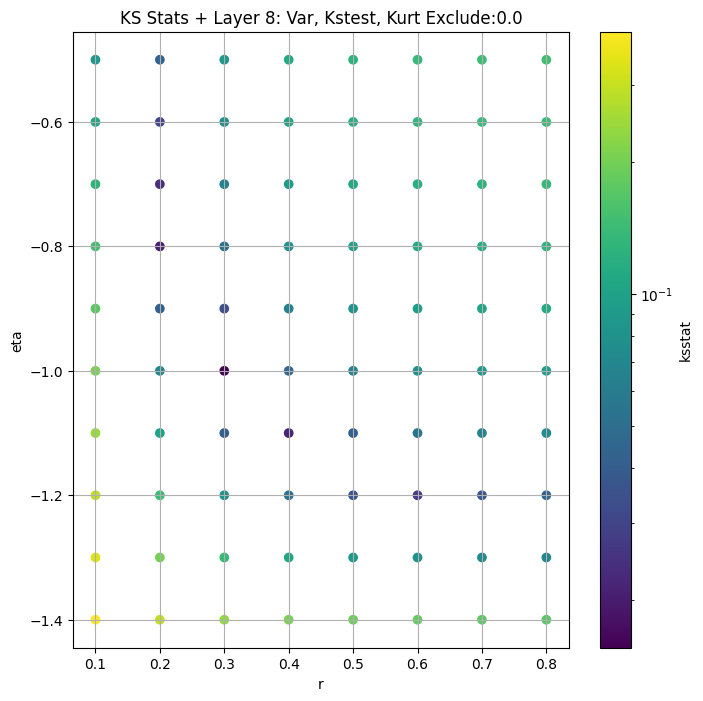

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.013616907060190475 0.075907975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.011508677377258525 0.06978138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.010388328958725657 0.06664723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.010559193856390814 0.06409986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.01166852100978455 0.061900575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.01215375418473319 0.058189686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.012614596527160349 0.05509768


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.013055555157518661 0.052430335


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01349087061640808 0.050084103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01487302873194185 0.047989987


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.017587872452077435 0.04279015
Number of samples: 100000, Without approximation : 26279936.0


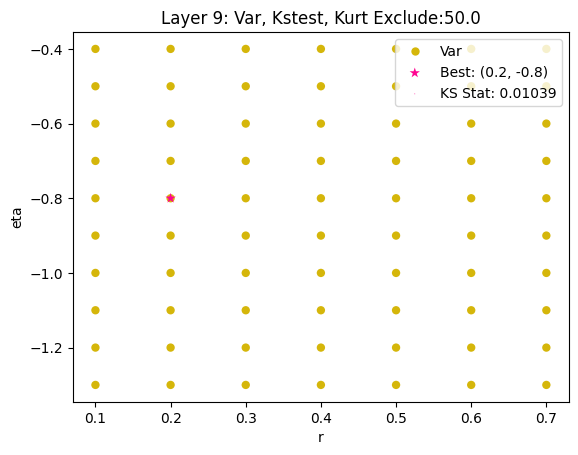

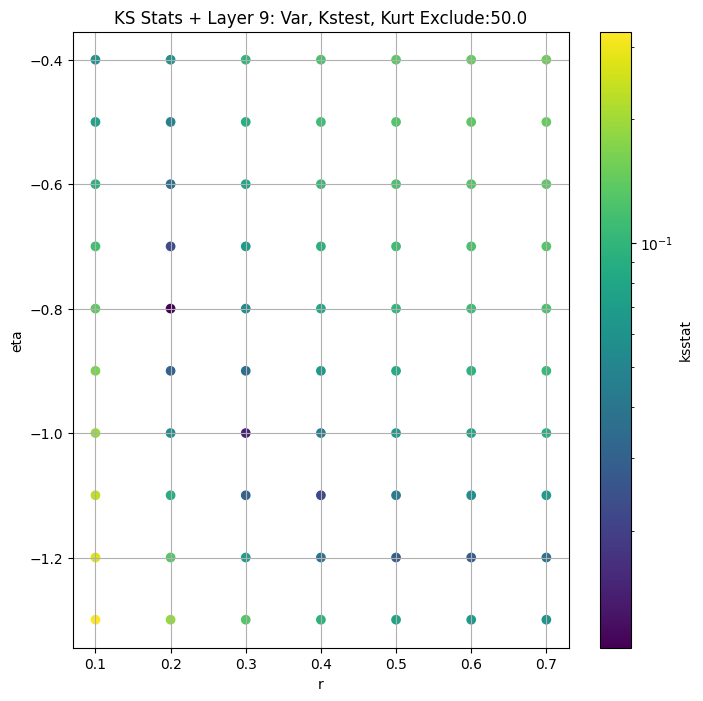

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5815.229500  5348.870000  6287.341300  -0.441054   -0.602250   
3      1326.074800  1255.579700  1397.486600   0.761781    0.544982   
4       292.659240   276.629640   309.142120   2.614651    2.138453   
5        55.126610    51.472590    58.957115   5.036825    3.927359   
6        10.025225     9.217633    10.903786   8.688152    6.635766   
7         1.785368     1.608343     1.986916  14.651720   10.383094   
8         0.343946     0.302026     0.396024  24.972425   15.453585   
9         0.075908     0.064915     0.091704  42.067000   20.209116   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.259446         1604.0             0.100450       20.0         20.0   
3        0.992033         6416.0             0.058632        4.3          2.1   
4        3.358012        25664.0             0.045271        4.7         -0.9   
5        7.035570       102656.0             0.033311        0.7         -0.9   
6       15.399898       410624.0             0.033190        1.2         -1.1   
7       29.135918      1642496.0             0.034023        0.9         -1.2   
8       71.256620      6569984.0             0.015530        0.3         -1.0   
9      144.260740     26279936.0             0.010388        0.2         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5939.813261                     0.0         5815.229500   
3        1023.036626                   200.0          876.928700   
4         822.943250                     0.0          292.659240   
5          47.478071                   200.0           49.670025   
6          22.069012                   500.0            7.642523   
7           4.615565                   150.0            1.526032   
8           0.012937                     0.0            0.343946   
9           0.000016                    50.0            0.066647   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.1454600197856475, var: 3593.183837890625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.13305533511518097, var: 3997.054931640625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.12071908061631542, var: 4453.1923828125


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.10919274858406358, var: 5023.30712890625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.10045038169551795, var: 5815.2294921875
Number of samples: 1604, Without approximation : 1604.0


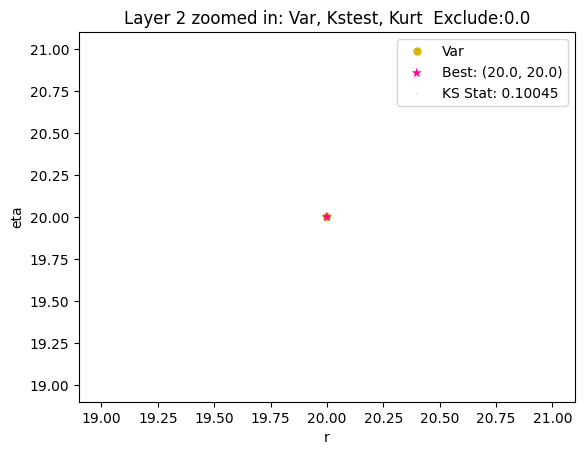

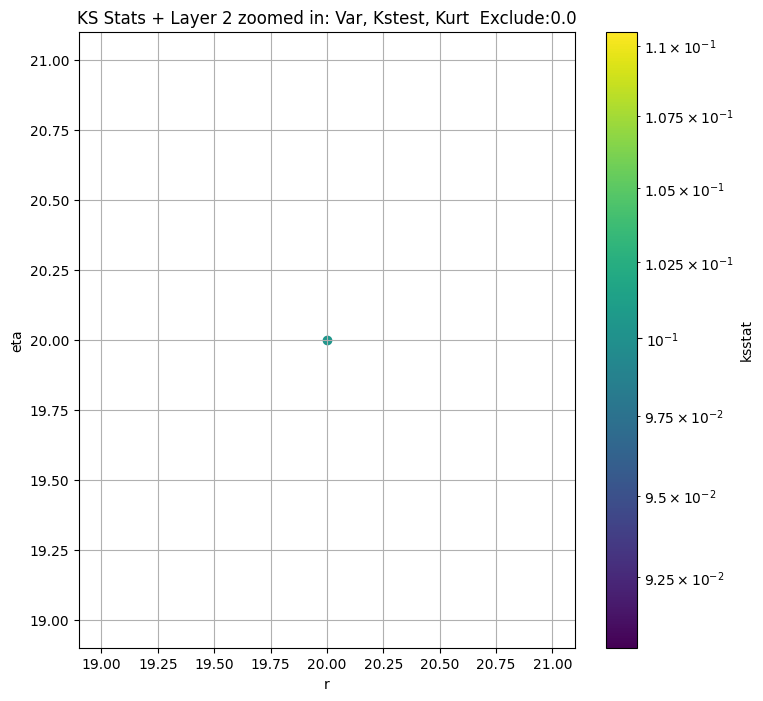

Layer 3


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + 100 = 300, ksstat: 0.07475131304658345, var: 752.9453125


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + 75 = 275, ksstat: 0.07034180365324438, var: 781.933837890625


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + 50 = 250, ksstat: 0.06592851425774293, var: 812.1838989257812


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + 25 = 225, ksstat: 0.0616355345151437, var: 843.693115234375


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + 0 = 200, ksstat: 0.058632292712292144, var: 876.9287109375


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + -25 = 175, ksstat: 0.058955311554302336, var: 912.3193359375


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + -50 = 150, ksstat: 0.05963945185955705, var: 950.7139282226562


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + -75 = 125, ksstat: 0.060822711260927254, var: 993.1209716796875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 200.0 + -100 = 100, ksstat: 0.06297067724996341, var: 1039.4417724609375
Number of samples: 6416, Without approximation : 6416.0


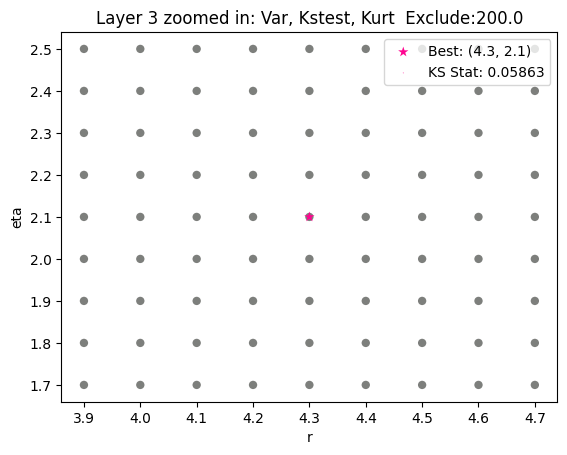

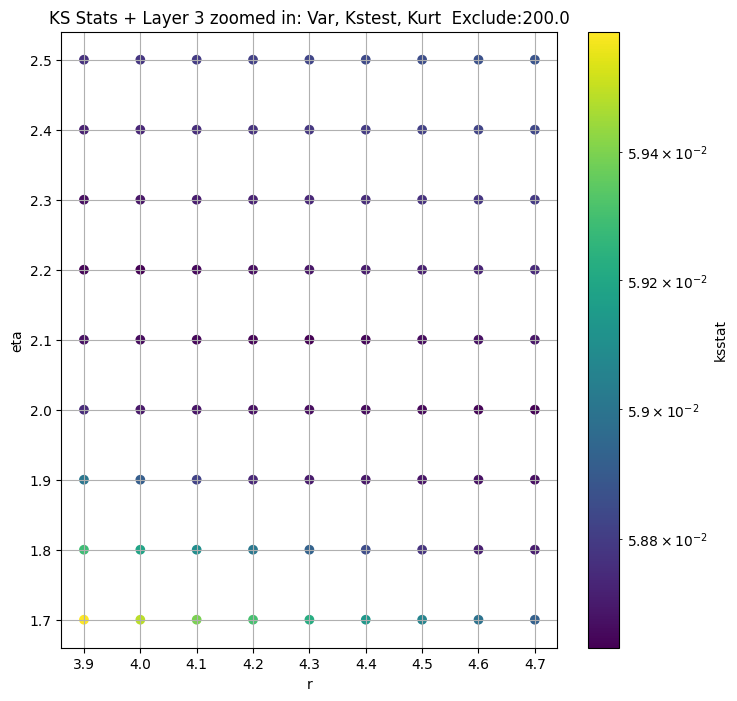

Layer 4


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.045333453289357895, var: 258.02044677734375


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.04531640189062208, var: 264.6778259277344


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.04532693915025776, var: 272.0176696777344


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.045310785885589344, var: 280.55645751953125


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.045271017150417814, var: 292.65924072265625
Number of samples: 25664, Without approximation : 25664.0


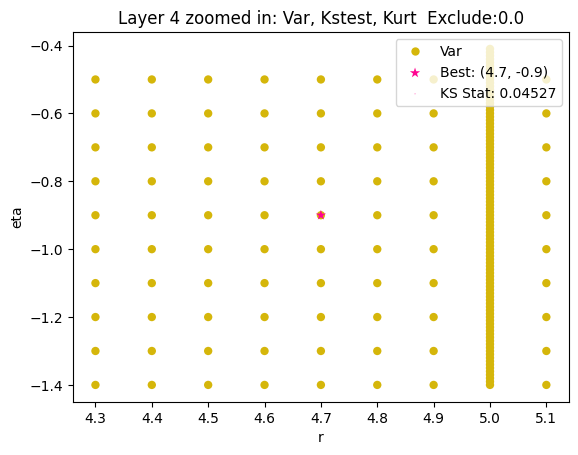

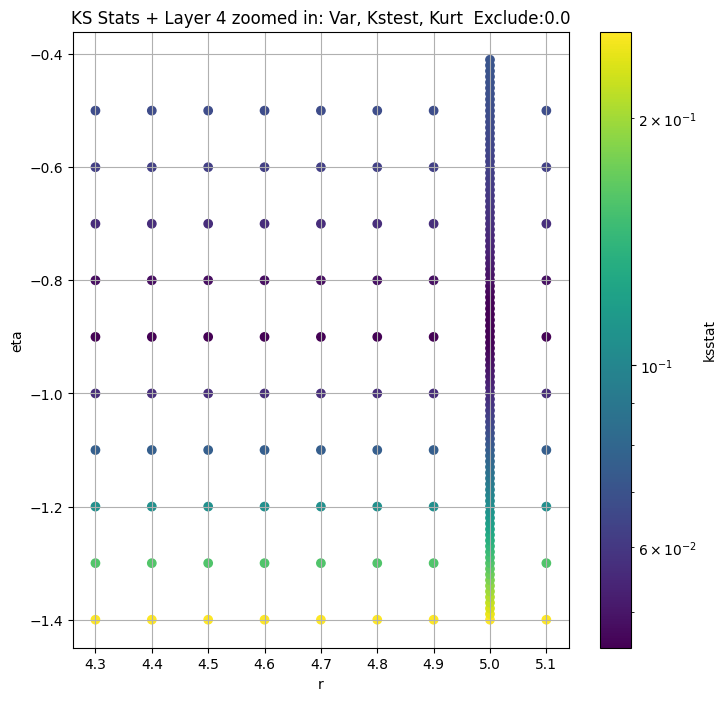

Layer 5


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + 100 = 300, ksstat: 0.03322003954178593, var: 47.90559768676758


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + 75 = 275, ksstat: 0.0332270233217451, var: 48.32470703125


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + 50 = 250, ksstat: 0.03323413527962071, var: 48.7570686340332


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + 25 = 225, ksstat: 0.03324141649428475, var: 49.20563507080078


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + 0 = 200, ksstat: 0.03317423450824053, var: 49.67002487182617


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + -25 = 175, ksstat: 0.033173189693734284, var: 50.156105041503906


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + -50 = 150, ksstat: 0.03318156699562036, var: 50.66872787475586


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + -75 = 125, ksstat: 0.03319031073620704, var: 51.21202087402344


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 200.0 + -100 = 100, ksstat: 0.03319954163417038, var: 51.794918060302734
Number of samples: 100000, Without approximation : 102656.0


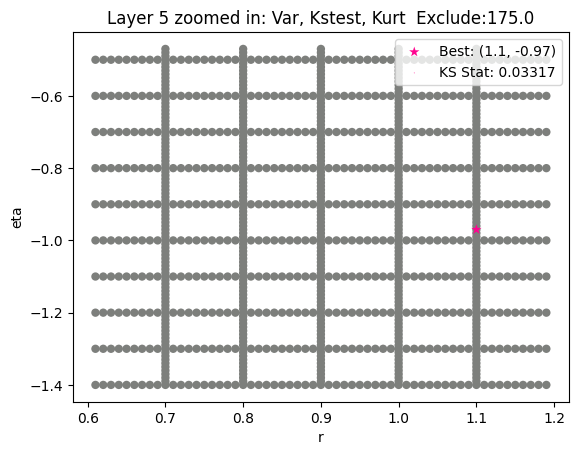

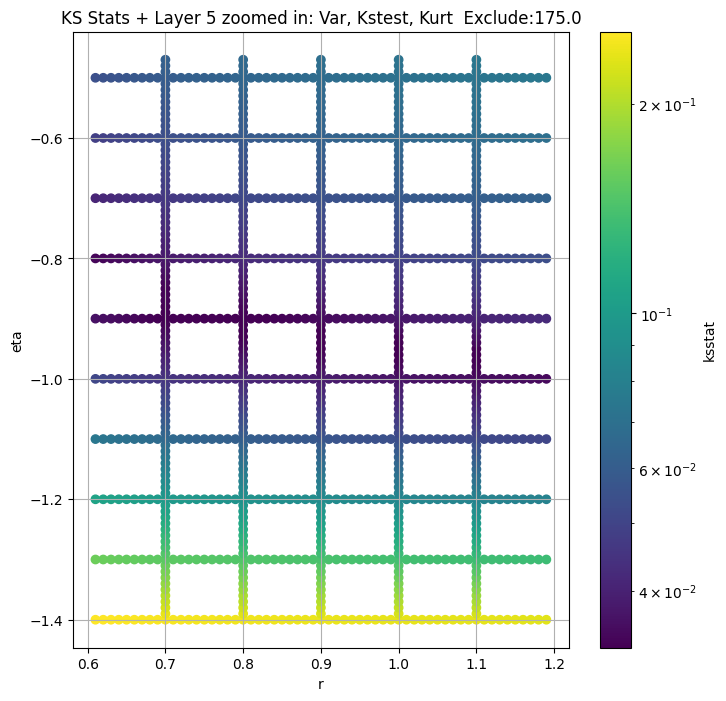

Layer 6


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 100 = 600, ksstat: 0.033076314891826386, var: 7.358745098114014


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 75 = 575, ksstat: 0.03301004528565343, var: 7.427139759063721


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 50 = 550, ksstat: 0.03304510924892878, var: 7.497171401977539


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 25 = 525, ksstat: 0.033081563926485036, var: 7.568990230560303


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 0 = 500, ksstat: 0.03299459396264176, var: 7.642522811889648


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -25 = 475, ksstat: 0.03303130055305048, var: 7.717935562133789


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -50 = 450, ksstat: 0.03306936016941703, var: 7.795429706573486


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -75 = 425, ksstat: 0.03307515292013785, var: 7.875131607055664


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -100 = 400, ksstat: 0.03300083211971683, var: 7.957162380218506
Number of samples: 100000, Without approximation : 410624.0


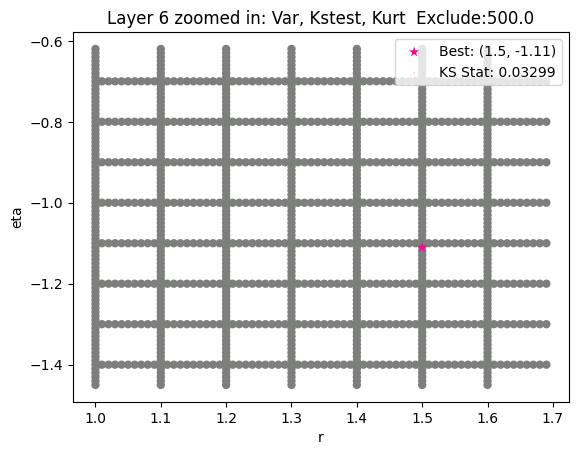

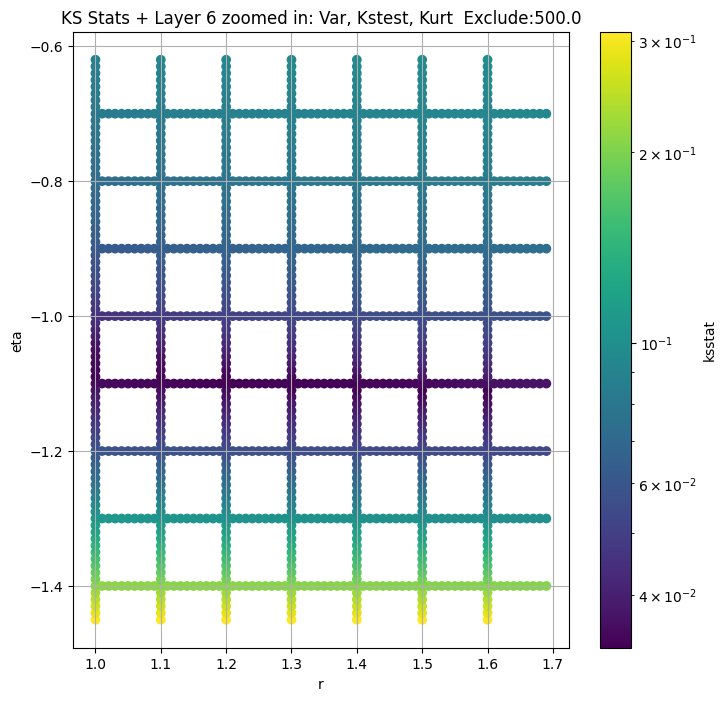

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.0335440541021807, var: 1.4261800050735474


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.033389814890618985, var: 1.4490163326263428


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.032905240156044124, var: 1.4731389284133911


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.03242724788994328, var: 1.4987186193466187


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.0326097219186372, var: 1.5260322093963623


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.03258110645928147, var: 1.555415391921997


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.03254259676249455, var: 1.5872739553451538


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.032881059851608385, var: 1.622390627861023


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.032443320823656585, var: 1.662088394165039
Number of samples: 100000, Without approximation : 1642496.0


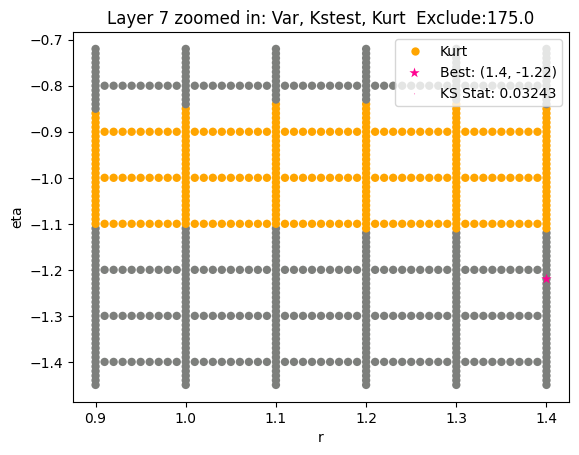

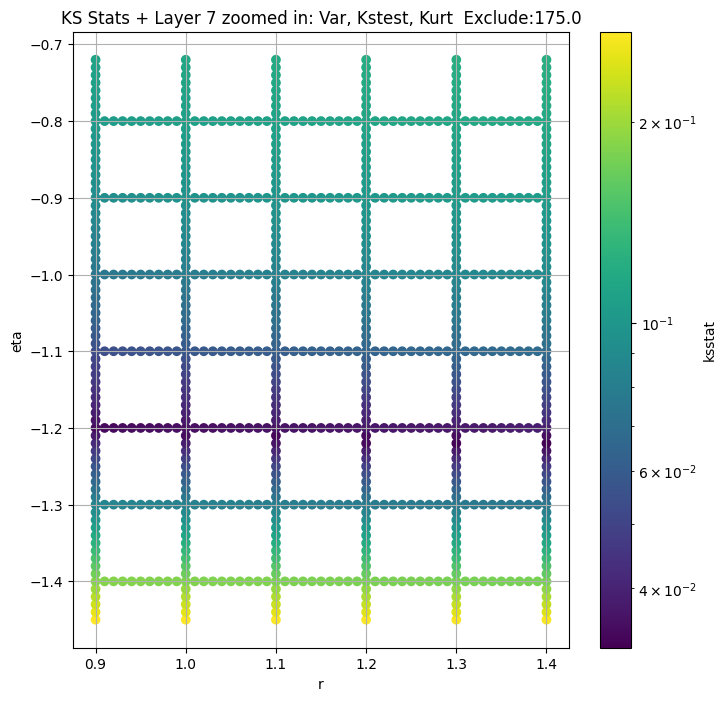

Layer 8


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.015946227867035145, var: 0.2935827374458313


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.01608748826221118, var: 0.3021479547023773


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.015563380629474488, var: 0.311902791261673


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.015781607025802225, var: 0.3236164450645447


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.01553004991653495, var: 0.3439459502696991
Number of samples: 100000, Without approximation : 6569984.0


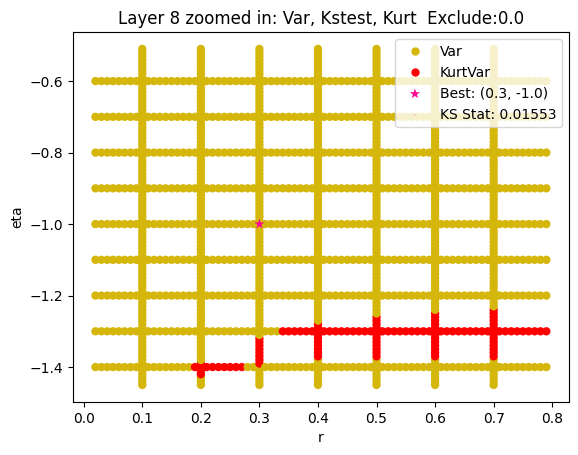

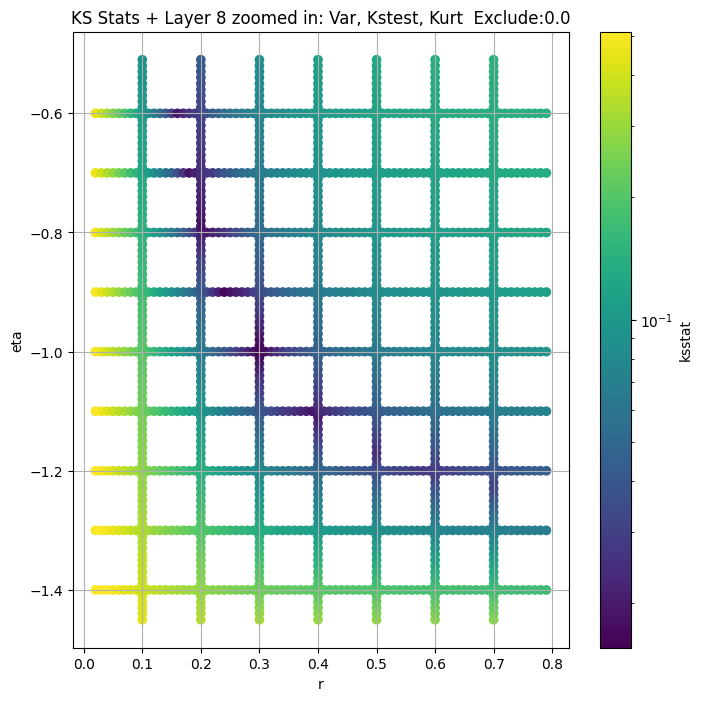

Layer 9


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 50.0 + 100 = 150, ksstat: 0.010962271142334612, var: 0.05818968638777733


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 50.0 + 75 = 125, ksstat: 0.010433264634997608, var: 0.05994945392012596


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 50.0 + 50 = 100, ksstat: 0.010225584959029366, var: 0.06190057471394539


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 50.0 + 25 = 75, ksstat: 0.010559193856390814, var: 0.06409986317157745


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 50.0 + 0 = 50, ksstat: 0.010388328958725657, var: 0.0666472315788269


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 50.0 + -25 = 25, ksstat: 0.01014408131056016, var: 0.06978137791156769


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 50.0 + -50 = 0, ksstat: 0.010240323868222934, var: 0.07590797543525696
Number of samples: 100000, Without approximation : 26279936.0


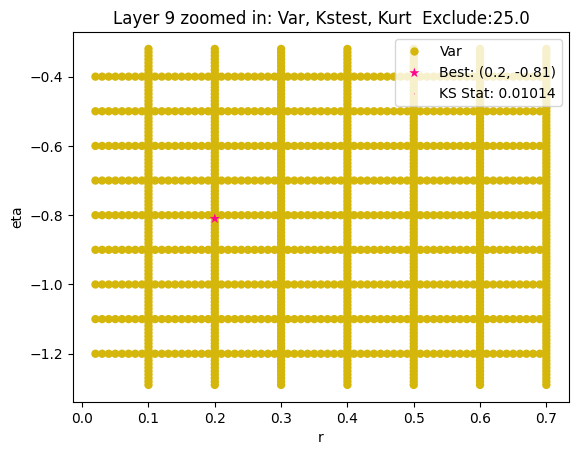

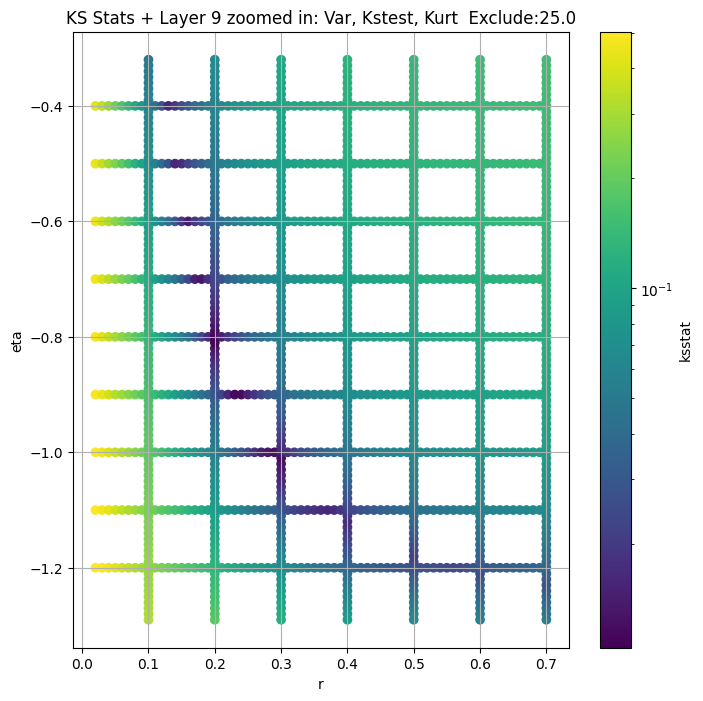

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5815.229500  5348.870000  6287.341300  -0.441054   -0.602250   
3      1326.074800  1255.579700  1397.486600   0.761781    0.544982   
4       292.659240   276.629640   309.142120   2.614651    2.138453   
5        55.126610    51.472590    58.957115   5.036825    3.927359   
6        10.025225     9.217633    10.903786   8.688152    6.635766   
7         1.785368     1.608343     1.986916  14.651720   10.383094   
8         0.343946     0.302026     0.396024  24.972425   15.453585   
9         0.075908     0.064915     0.091704  42.067000   20.209116   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.259446         1604.0             0.100450       20.0         20.0   
3        0.992033         6416.0             0.058632        4.3          2.1   
4        3.358012        25664.0             0.045271        4.7         -0.9   
5        7.035570       102656.0             0.033311        0.7         -0.9   
6       15.399898       410624.0             0.033190        1.2         -1.1   
7       29.135918      1642496.0             0.034023        0.9         -1.2   
8       71.256620      6569984.0             0.015530        0.3         -1.0   
9      144.260740     26279936.0             0.010388        0.2         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5939.813261                     0.0         5815.229500   
3        1023.036626                   200.0          876.928700   
4         822.943250                     0.0          292.659240   
5          47.478071                   200.0           50.156105   
6          22.069012                   500.0            7.642523   
7           4.615565                   150.0            1.498719   
8           0.012937                     0.0            0.343946   
9           0.000016                    50.0            0.069781   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.100450    20.0     20.00   
3                     0.016929          0.058632     4.3      2.10   
4                     0.008471          0.045271     4.7     -0.90   
5                     0.004237          0.033173     1.1     -0.97   
6                     0.002119          0.032995     1.5     -1.11   
7                     0.001060          0.032427     1.4     -1.22   
8                     0.000530          0.015530     0.3     -1.00   
9                     0.000265          0.010144     0.2     -0.81   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      5939.813261                  0.0          189  
3      1023.036626                200.0          505  
4       822.943250                  0.0          901  
5       103.860716                175.0         1604  
6        25.365657                500.0         1604  
7         6.507062                175.0         1804  
8         0.012937                  0.0         7704  
9         0.000017                 25.0        18270

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

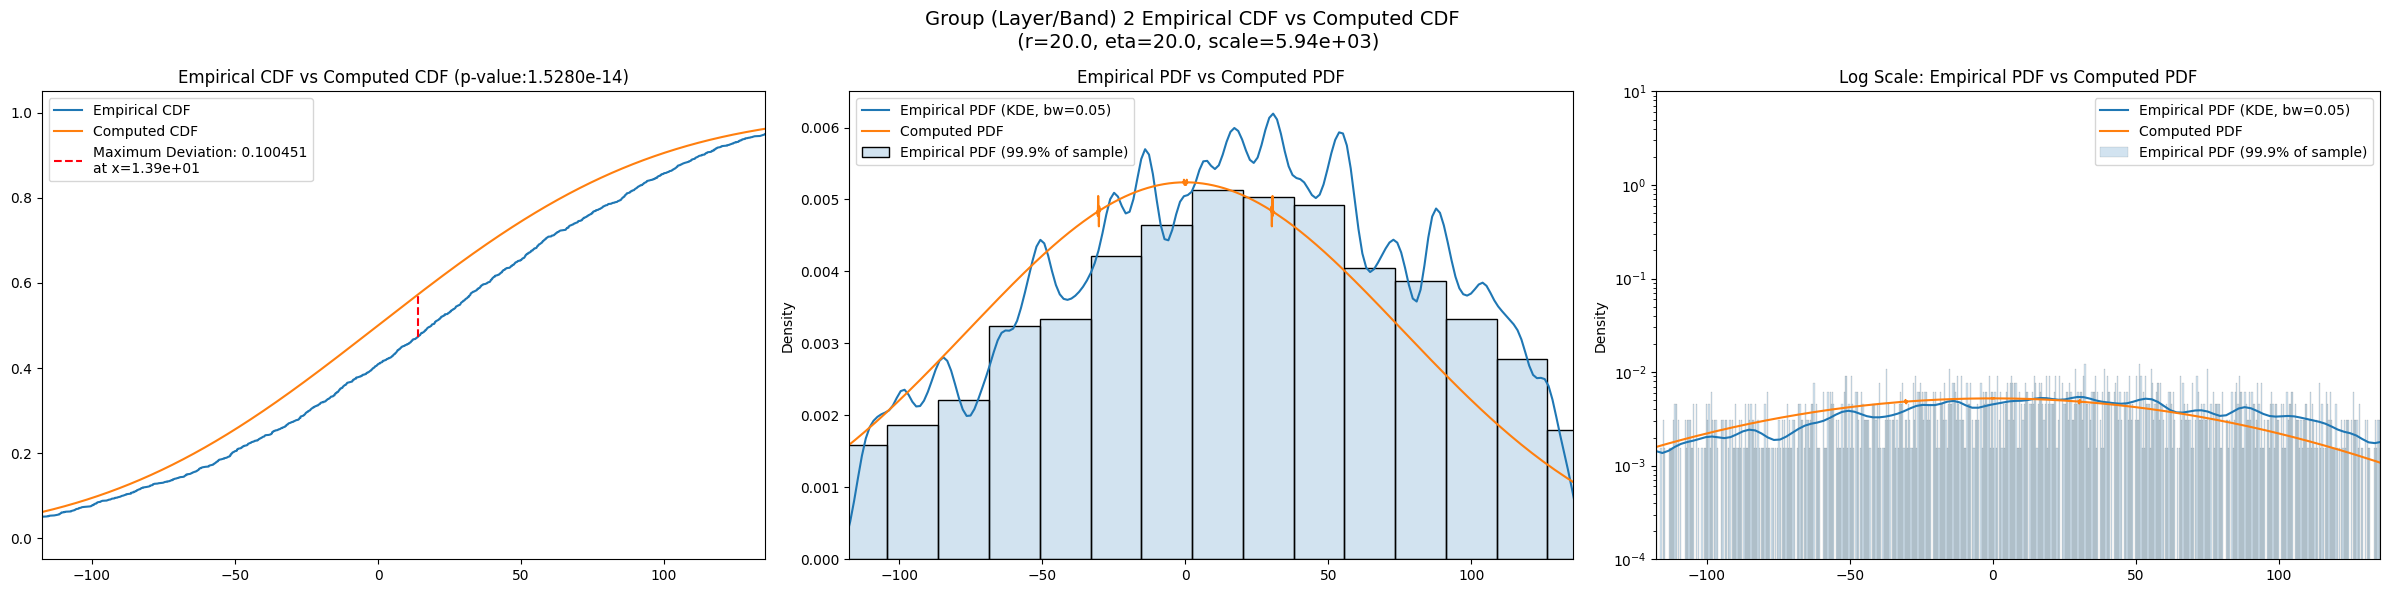

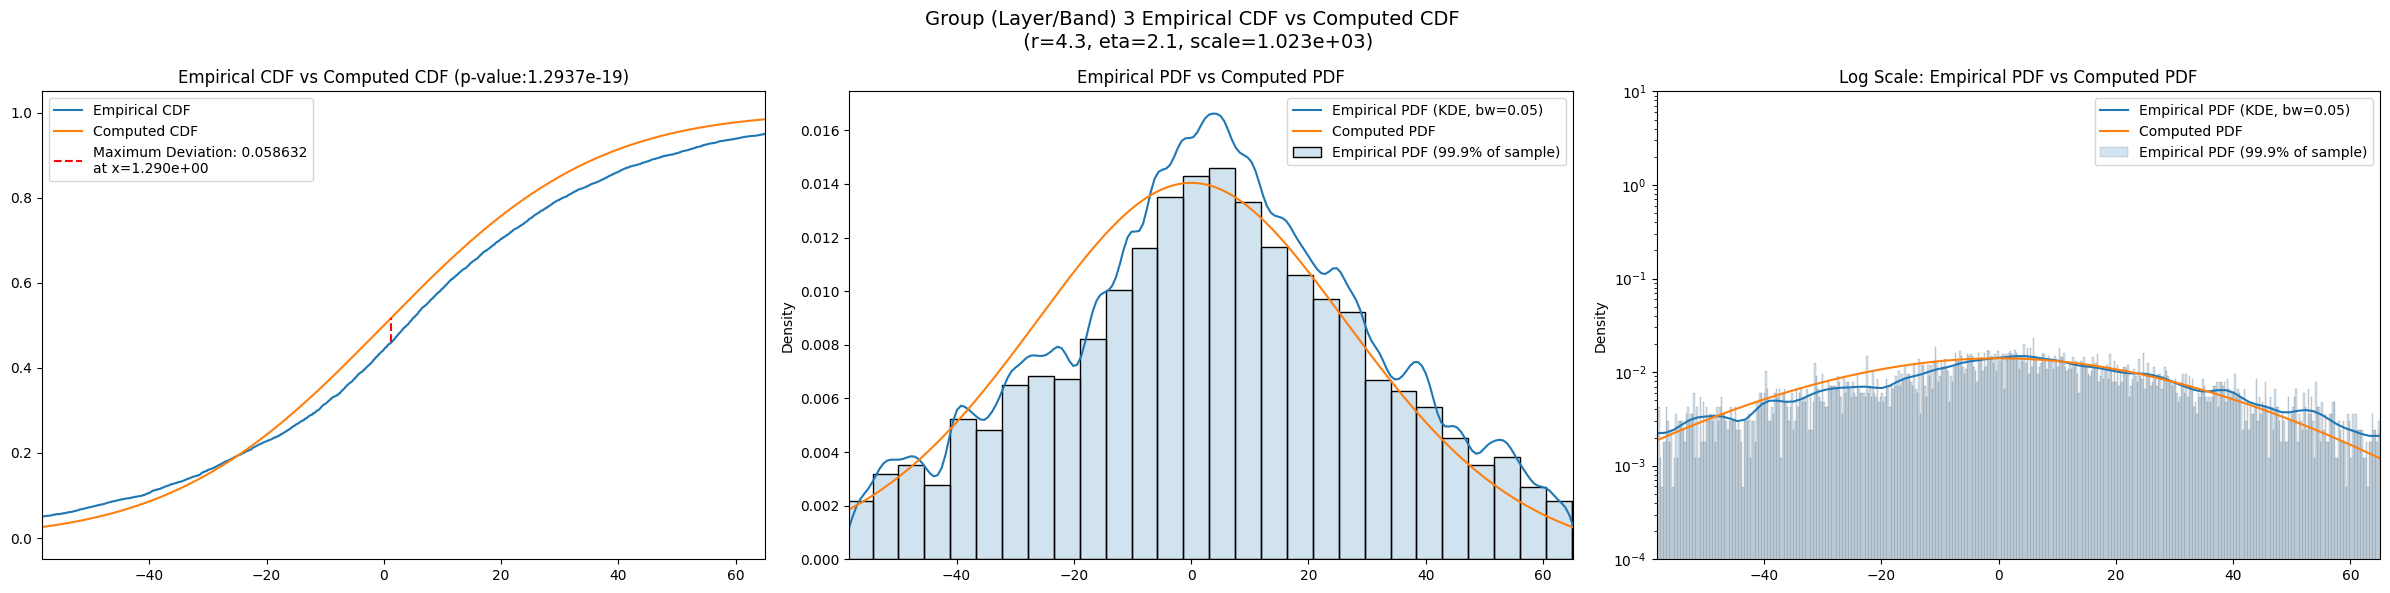

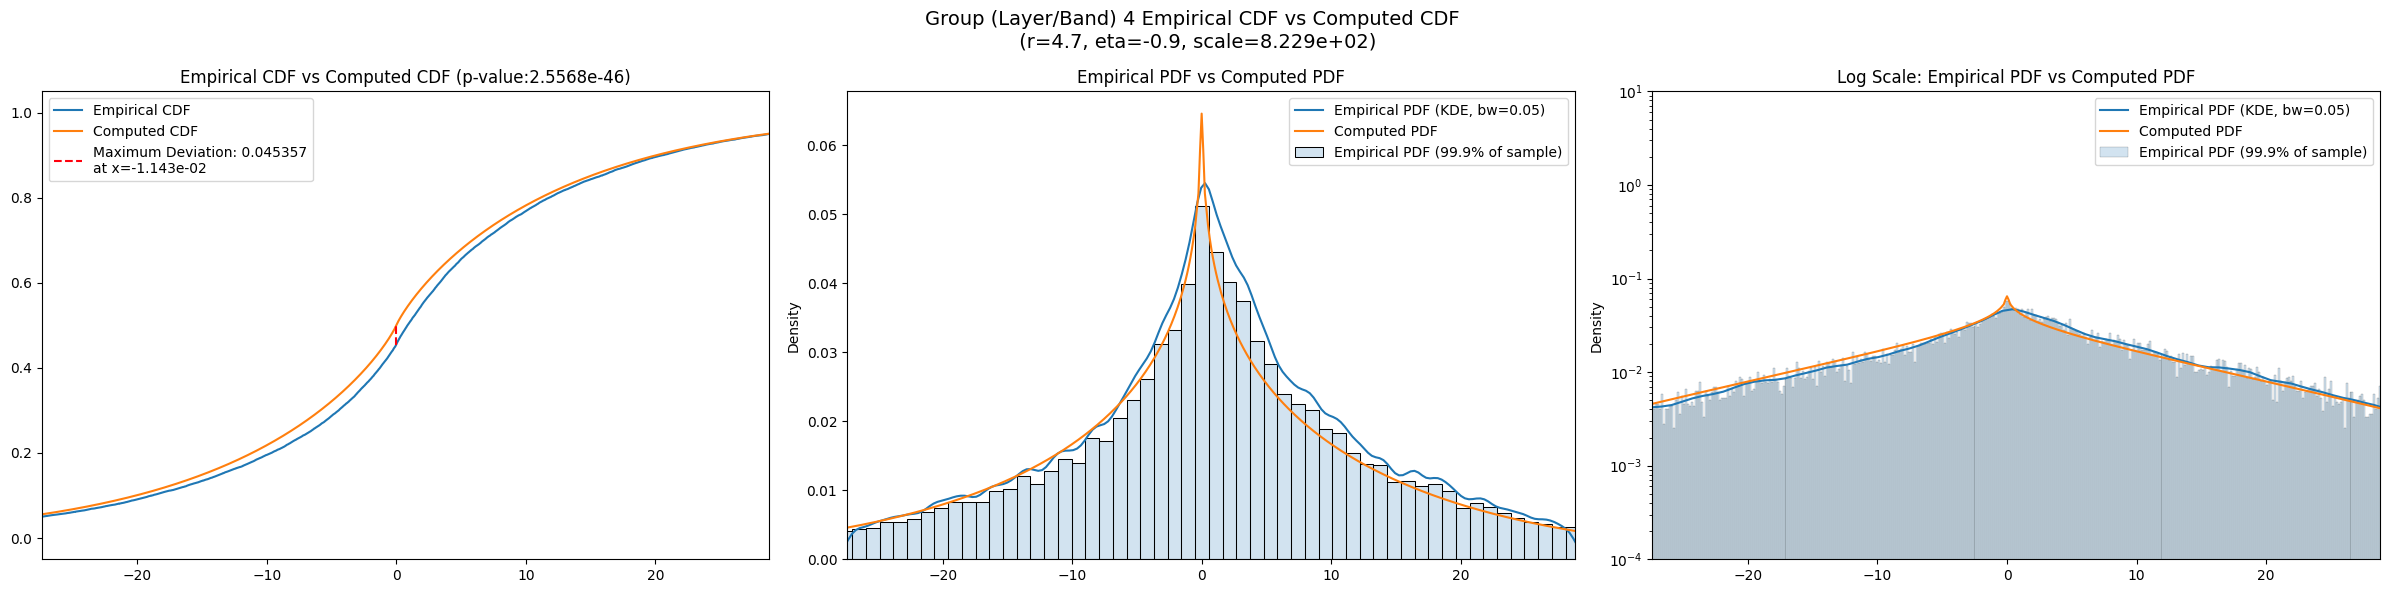

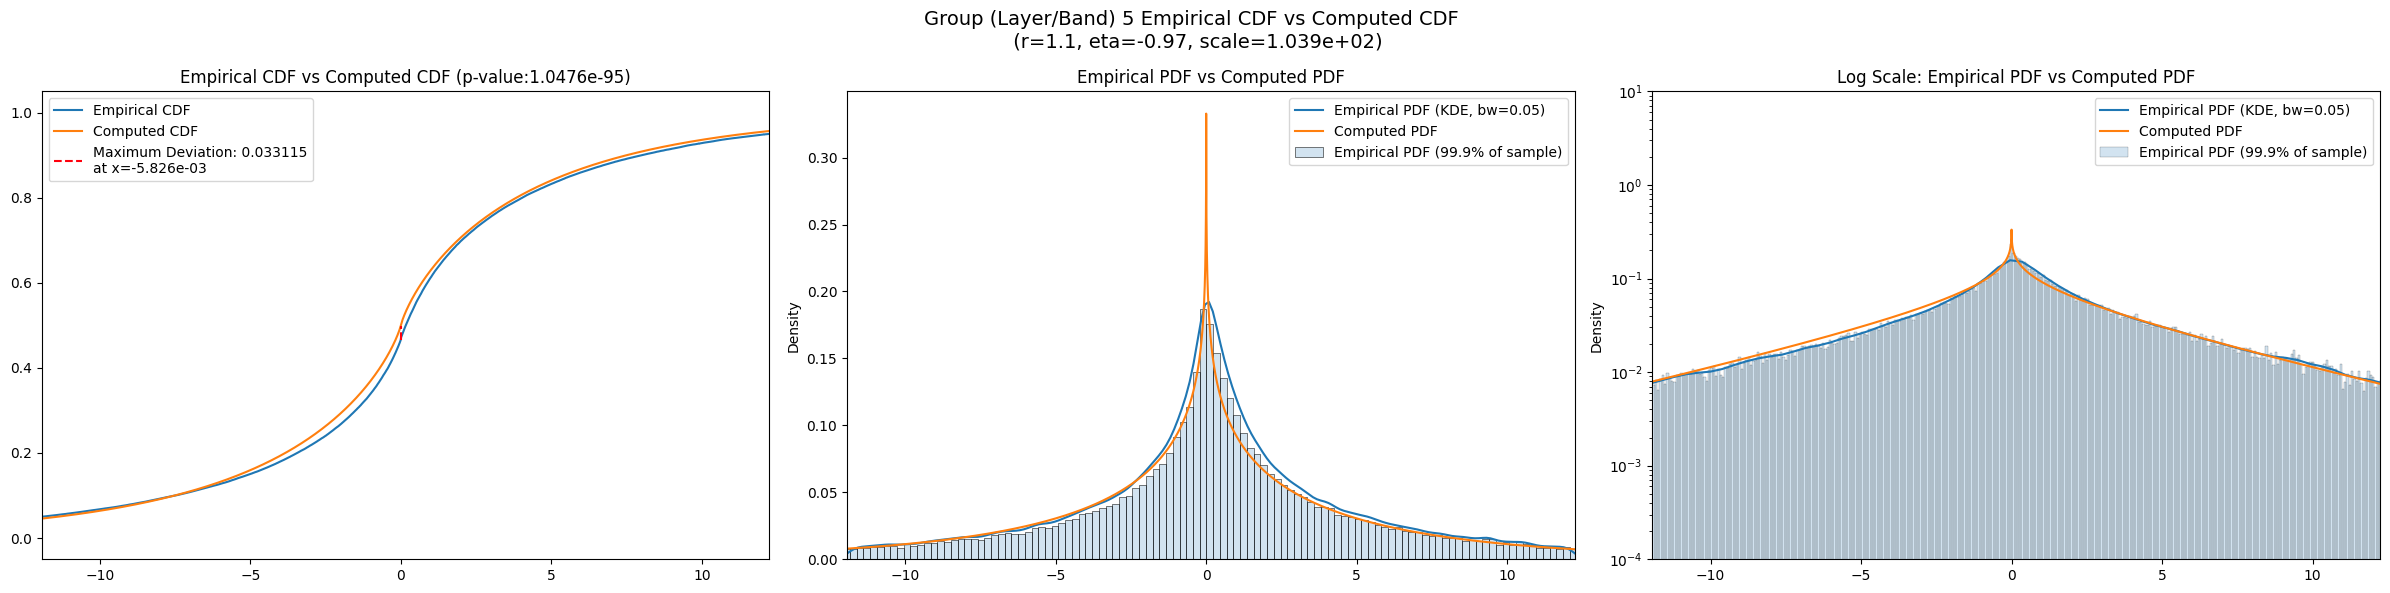

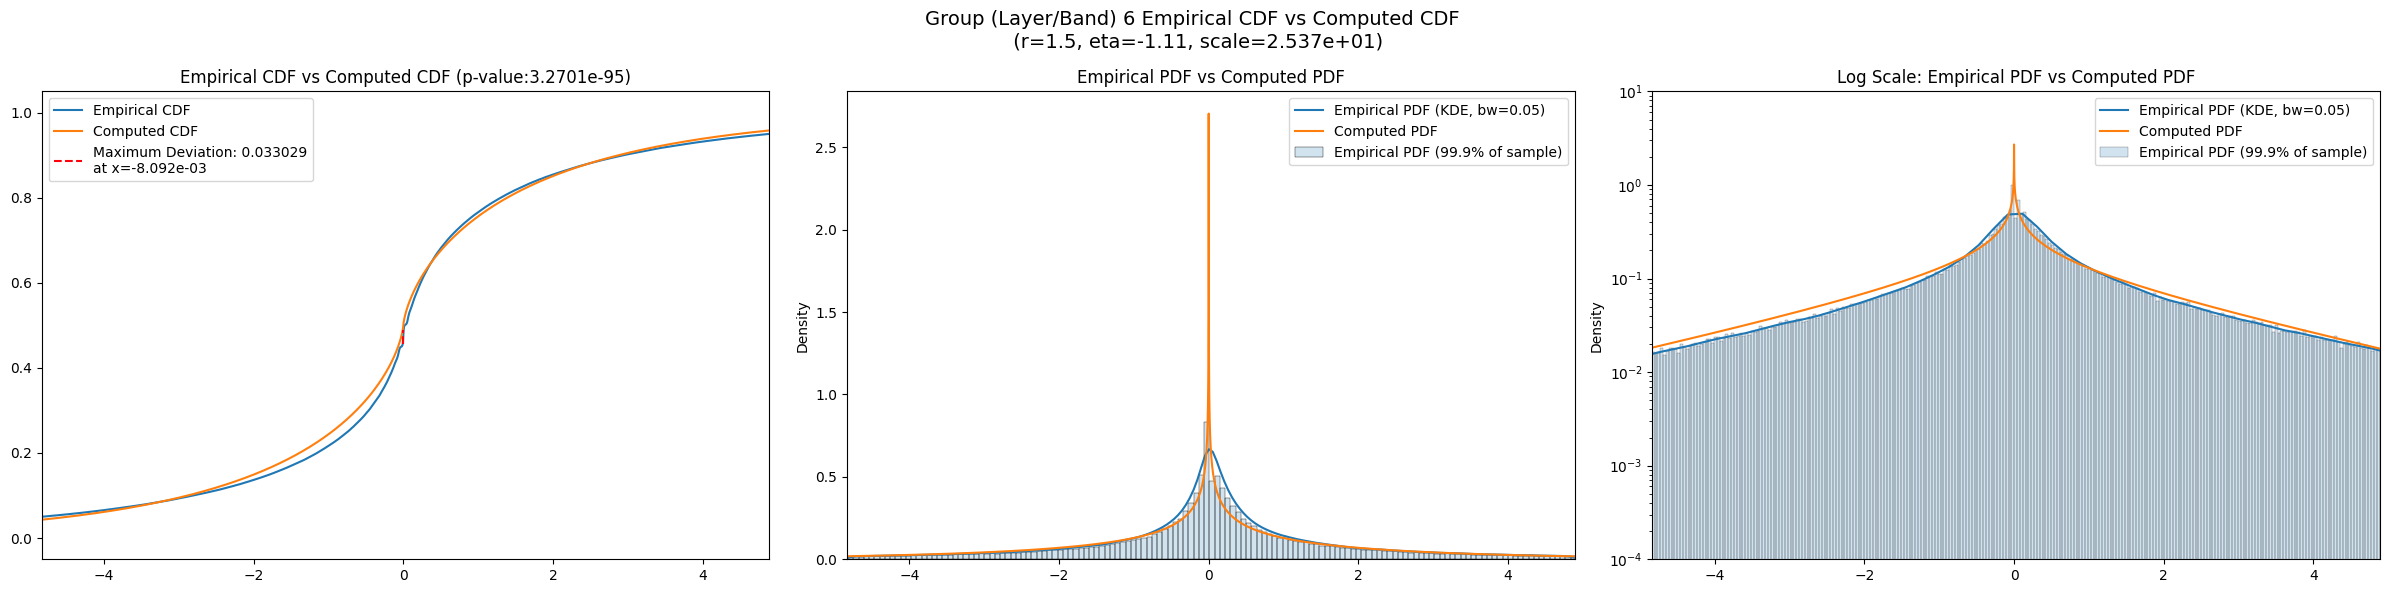

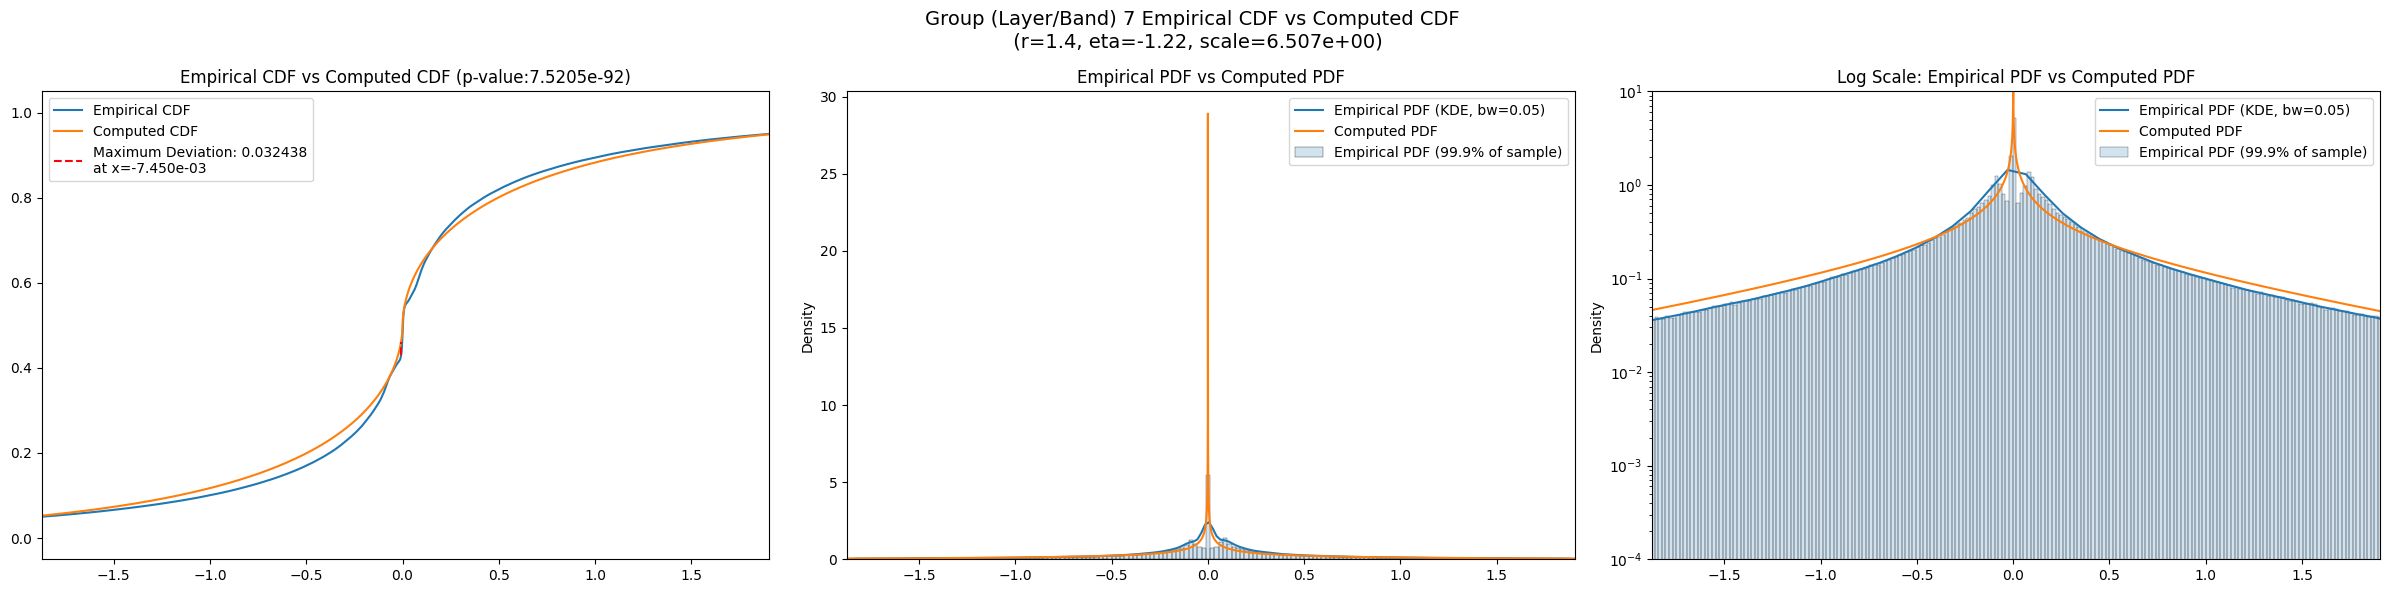

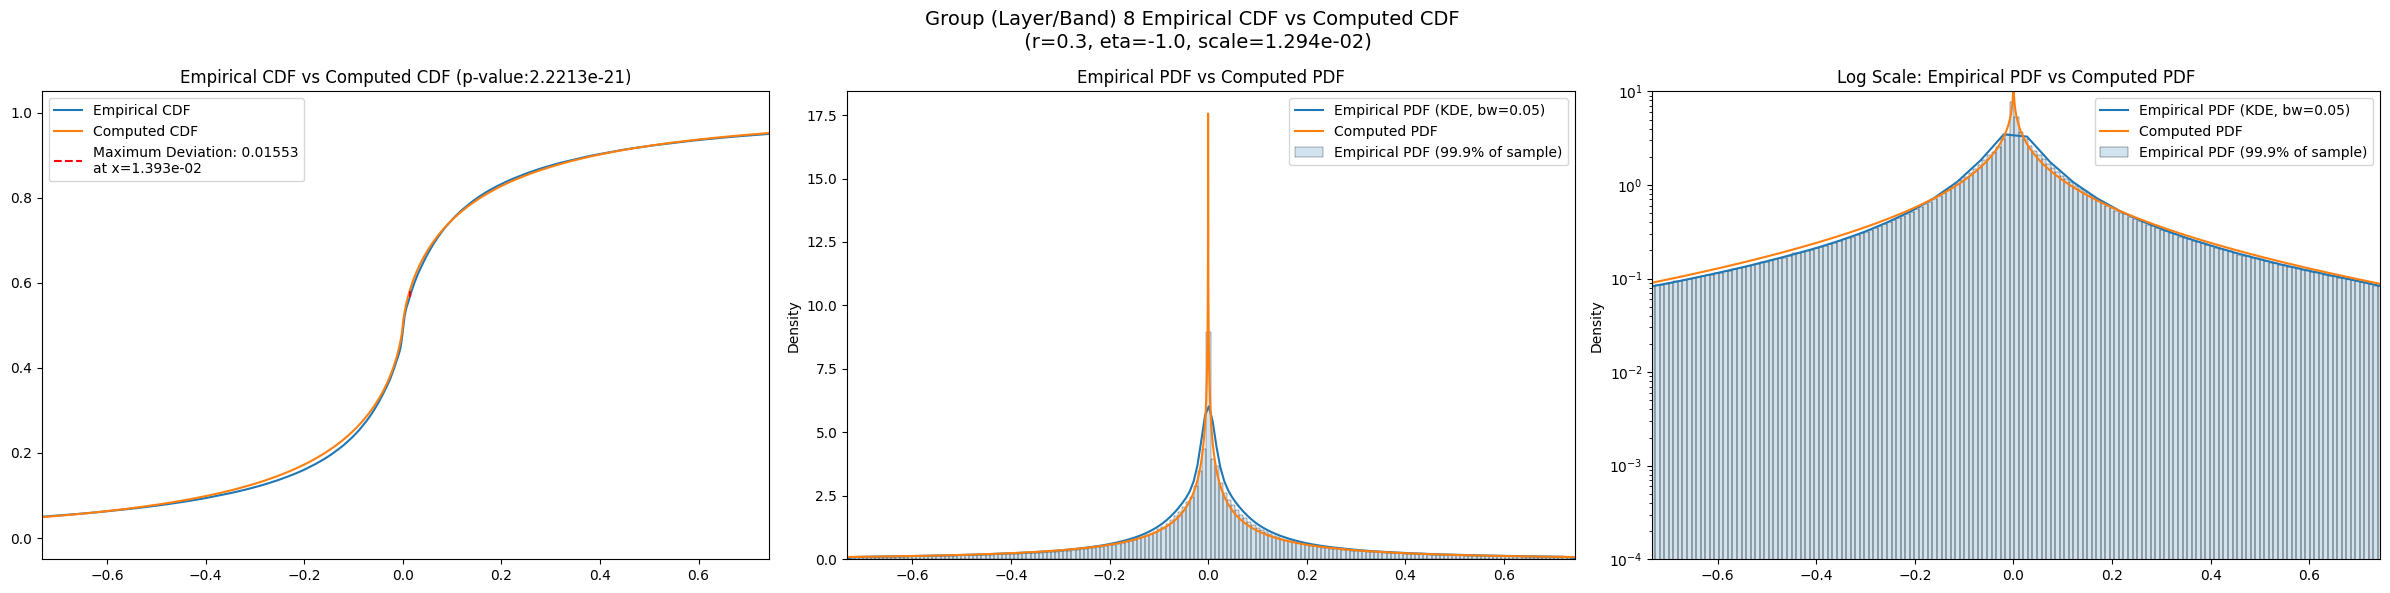

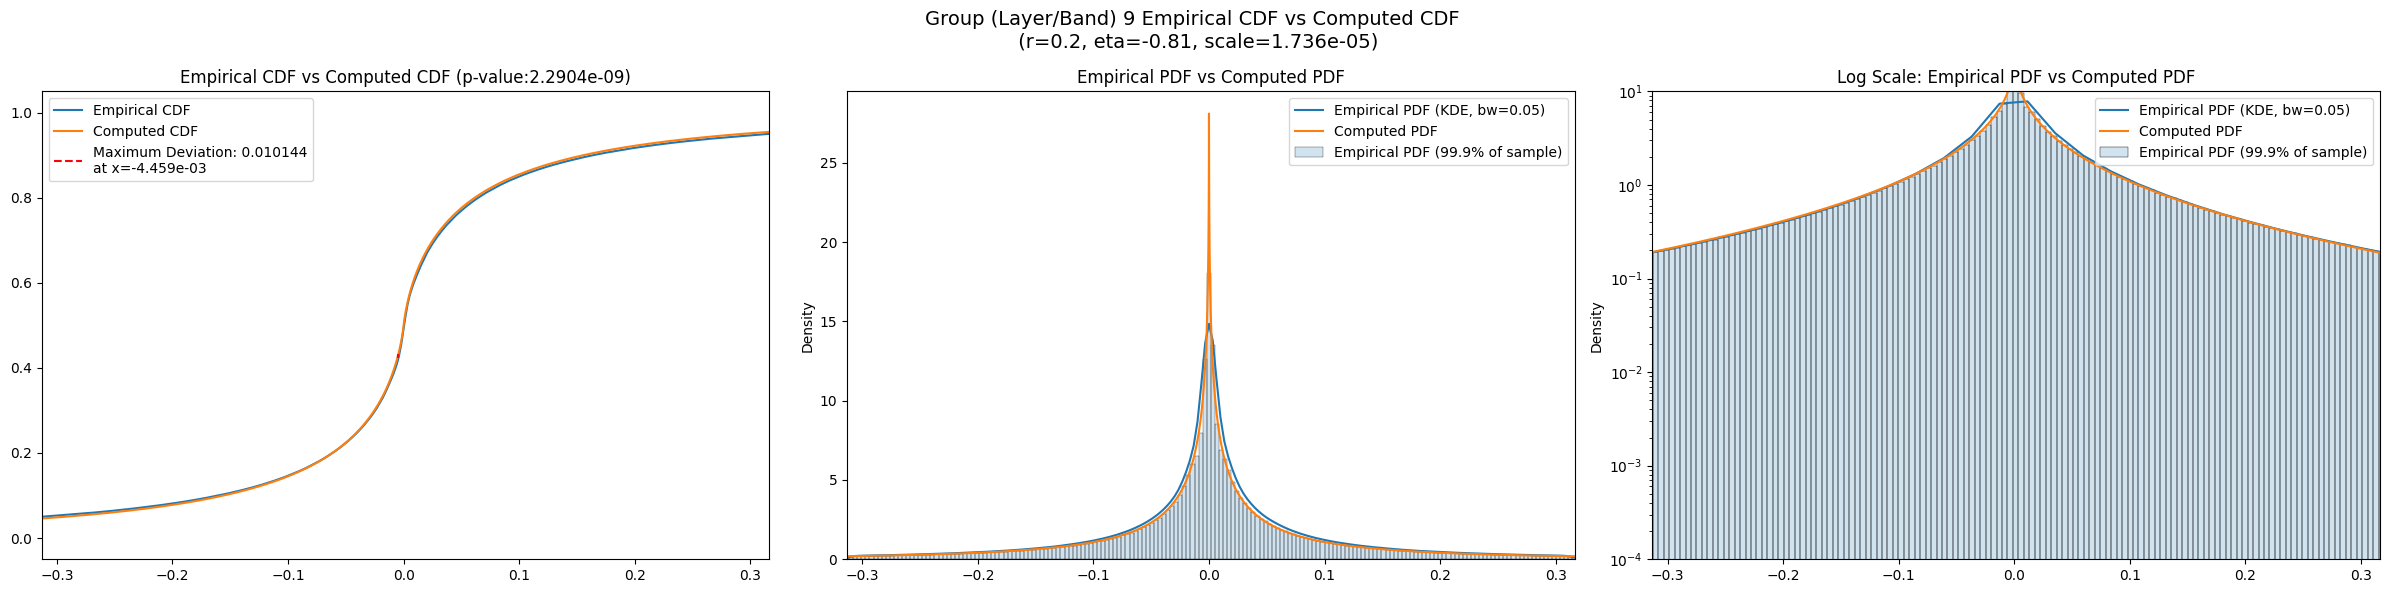

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5815.229500  5348.870000  6287.341300  -0.441054   -0.602250   
3      1326.074800  1255.579700  1397.486600   0.761781    0.544982   
4       292.659240   276.629640   309.142120   2.614651    2.138453   
5        55.126610    51.472590    58.957115   5.036825    3.927359   
6        10.025225     9.217633    10.903786   8.688152    6.635766   
7         1.785368     1.608343     1.986916  14.651720   10.383094   
8         0.343946     0.302026     0.396024  24.972425   15.453585   
9         0.075908     0.064915     0.091704  42.067000   20.209116   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.259446         1604.0             0.100450       20.0         20.0   
3        0.992033         6416.0             0.058632        4.3          2.1   
4        3.358012        25664.0             0.045271        4.7         -0.9   
5        7.035570       102656.0             0.033311        0.7         -0.9   
6       15.399898       410624.0             0.033190        1.2         -1.1   
7       29.135918      1642496.0             0.034023        0.9         -1.2   
8       71.256620      6569984.0             0.015530        0.3         -1.0   
9      144.260740     26279936.0             0.010388        0.2         -0.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       86.932700              0.096124          2.372860e-13   
3      ...       29.005500              0.059311          4.626950e-20   
4      ...       11.873800              0.060151          3.689370e-81   
5      ...        4.310520              0.068847          0.000000e+00   
6      ...        1.462360              0.078613          0.000000e+00   
7      ...        0.497495              0.083777          0.000000e+00   
8      ...        0.190867              0.079594          0.000000e+00   
9      ...        0.079713              0.080742          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          94.200500             0.098745         4.569640e-14  76.013700   
3          33.532500             0.059400         4.035540e-20  25.168400   
4          10.145800             0.045886         2.137430e-47   8.632250   
5           3.655760             0.044954        1.036250e-180   2.994770   
6           1.249040             0.053215         0.000000e+00   0.992592   
7           0.401138             0.064625         0.000000e+00   0.313839   
8           0.165407             0.054612         0.000000e+00   0.126412   
9           0.069214             0.055472         0.000000e+00   0.053218   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.096387   2.015210e-13          1.528185e-14  
3           0.058639   1.280030e-19          1.294014e-19  
4           0.049120   2.980760e-54          3.818553e-46  
5           0.050002  1.696680e-223          1.393500e-98  
6           0.056217   0.000000e+00          0.000000e+00  
7           0.065880   0.000000e+00          0.000000e+00  
8           0.055179   0.000000e+00          0.000000e+00  
9           0.055883   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.100450                 0.033804          0.100450   
3                 0.058632                 0.016929          0.058632   
4                 0.045271                 0.008471          0.045271   
5                 0.033311                 0.004237          0.033173   
6                 0.033190                 0.002119          0.032995   
7                 0.034023                 0.001060          0.032427   
8                 0.015530                 0.000530          0.015530   
9                 0.010388                 0.000265          0.010144   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.096124             0.098745       0.096387  
3                  0.059311             0.059400       0.058639  
4                  0.060151             0.045886       0.049120  
5                  0.068847             0.044954       0.050002  
6                  0.078613             0.053215       0.056217  
7                  0.083777             0.064625       0.065880  
8                  0.079594             0.054612       0.055179  
9                  0.080742             0.055472       0.055883

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             5815.229500          0.100450    20.0     20.00  5939.813261   
3              876.928700          0.058632     4.3      2.10  1023.036626   
4              292.659240          0.045271     4.7     -0.90   822.943250   
5               50.156105          0.033173     1.1     -0.97   103.860716   
6                7.642523          0.032995     1.5     -1.11    25.365657   
7                1.498719          0.032427     1.4     -1.22     6.507062   
8                0.343946          0.015530     0.3     -1.00     0.012937   
9                0.069781          0.010144     0.2     -0.81     0.000017   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                    200.0  
4                      0.0  
5                    175.0  
6                    500.0  
7                    175.0  
8                      0.0  
9                     25.0

In [21]:
eng.quit()